<font size="+3"><strong>Autoregressive Models</strong></font>

In [115]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
#from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data 
## Import

In [116]:
df = pd.read_csv("./task3/P2-P2.5-nairobi3.txt").set_index("timestamp").squeeze()
#df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")
df.head()

timestamp
2018-09-01 03:00:00+03:00    17.541667
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
Name: P2, dtype: float64

In [117]:
assert isinstance(df, pd.Series), f"`df` should be a Seriess, not type {type(df)}"
assert len(df) == 2928, f"`df` should have 2928 observations, not {len(df)}"
assert df.isnull().sum() == 0

In [118]:
df.corr(df.shift(1))

0.6506785333937846

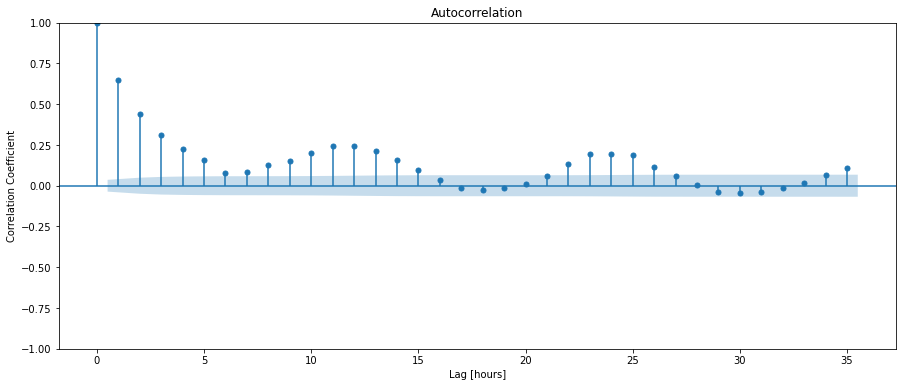

In [119]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [120]:
df.shift(1).corr(df.shift(2))

0.6506810900745511

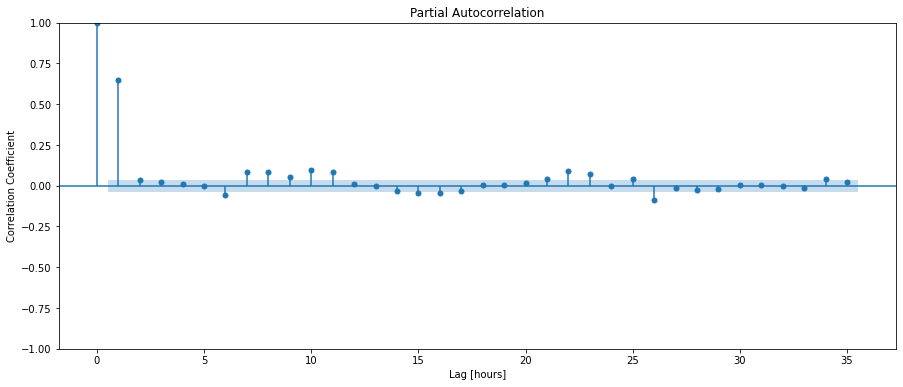

In [121]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

## Split

In [122]:
int(len(df)*.95)

2781

In [123]:
cutoff_test = int(len(df)*.95)

y_train = df.iloc[:cutoff_test]
y_test = df.iloc[cutoff_test:]

In [124]:
len(y_train) +len(y_test) == len(df)

True

In [125]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.22
Baseline MAE: 3.71


# Build Model
## Baseline

**Task:** Calculate the baseline mean absolute error for your model.


In [126]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.22
Baseline MAE: 3.71


**Task :** Instantiate an [`AutoReg`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html) model and fit it to the training data `y_train`. Be sure to set the `lags` argument to `26`.

In [127]:
model = AutoReg(y_train, lags=26).fit()

c:\Users\Zamani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [128]:
model.predict()

2018-09-01 03:00:00+03:00         NaN
2018-09-01 04:00:00+03:00         NaN
2018-09-01 05:00:00+03:00         NaN
2018-09-01 06:00:00+03:00         NaN
2018-09-01 07:00:00+03:00         NaN
                               ...   
2018-12-25 19:00:00+03:00    8.452835
2018-12-25 20:00:00+03:00    8.706514
2018-12-25 21:00:00+03:00    7.862413
2018-12-25 22:00:00+03:00    7.766388
2018-12-25 23:00:00+03:00    6.484643
Freq: H, Length: 2781, dtype: float64

In [129]:
model.predict().isnull().sum()

26

In [130]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:], y_pred)
print("Training MAE:", training_mae.round(3))

Training MAE: 2.281


In [131]:
#y_train_resid = y_train - y_pred  when i use this the residual plot was misbehaving, recheck it again
y_train_resid = model.resid
y_train_resid.tail()

timestamp
2018-12-25 19:00:00+03:00   -0.392002
2018-12-25 20:00:00+03:00   -1.573180
2018-12-25 21:00:00+03:00   -0.735747
2018-12-25 22:00:00+03:00   -2.022221
2018-12-25 23:00:00+03:00   -0.061916
dtype: float64

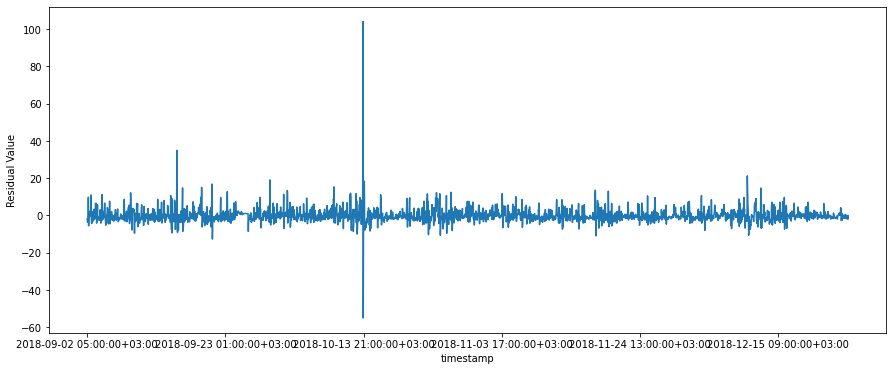

In [132]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value",ax=ax);

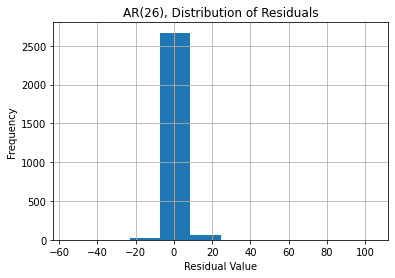

In [133]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(26), Distribution of Residuals");

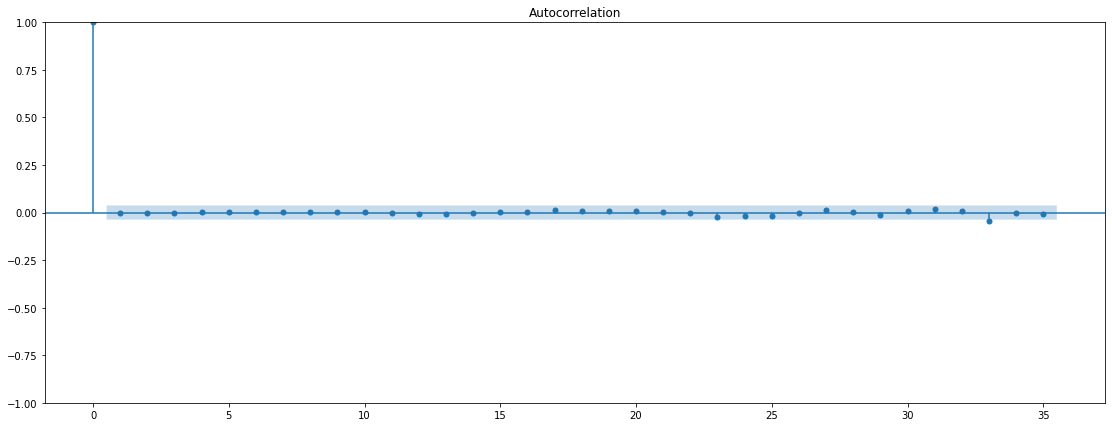

In [134]:
fig, ax = plt.subplots(figsize=(19, 7))
plot_acf(y_train_resid, ax=ax);

In [135]:
#y_test.index.tz_localize("UTC").tz_convert("Africa/Nairobi")
y_test.index.min()

'2018-12-26 00:00:00+03:00'

In [136]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 3.0136439495039116


c:\Users\Zamani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



In [137]:
df_pred_test = pd.DataFrame({"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index)

In [138]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show();

**Task :** Perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`. 


In [139]:
df_pred_test.head

<bound method NDFrame.head of                               y_test  y_pred
timestamp                                   
2018-12-26 00:00:00+03:00   5.679091     NaN
2018-12-26 01:00:00+03:00   5.362500     NaN
2018-12-26 02:00:00+03:00   4.786667     NaN
2018-12-26 03:00:00+03:00   4.956667     NaN
2018-12-26 04:00:00+03:00   5.055833     NaN
...                              ...     ...
2018-12-31 22:00:00+03:00   7.060833     NaN
2018-12-31 23:00:00+03:00   7.854167     NaN
2019-01-01 00:00:00+03:00   9.755833     NaN
2019-01-01 01:00:00+03:00  12.665000     NaN
2019-01-01 02:00:00+03:00  18.803333     NaN

[147 rows x 2 columns]>

c:\Users\Zamani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



2018-12-26 00:00:00+03:00    6.717606
Freq: H, dtype: float64

In [157]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred = model.forecast()
    
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

KeyError: "None of [DatetimeIndex(['2018-12-26 00:00:00+03:00'], dtype='datetime64[ns, pytz.FixedOffset(180)]', freq='H')] are in the [index]"

In [162]:
y_pred_wfv = pd.Series()
missing_index = y_test.index.difference(y_pred_wfv.index)
missing_index

C:\Users\Zamani\AppData\Local\Temp/ipykernel_2868/1858260972.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



pandas.core.indexes.base.Index

In [141]:
len(y_test)

147

In [142]:
history = y_train.copy()

In [143]:
history.tail(1)

timestamp
2018-12-25 23:00:00+03:00    6.422727
Name: P2, dtype: float64

In [144]:
model = AutoReg(history, lags=26).fit()

c:\Users\Zamani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [145]:
model.forecast()

2018-12-26 00:00:00+03:00    6.717606
Freq: H, dtype: float64

In [146]:
y_test.head(1)

timestamp
2018-12-26 00:00:00+03:00    5.679091
Name: P2, dtype: float64

In [147]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))


ValueError: Found input variables with inconsistent numbers of samples: [147, 1]

# Communicate Results

In [ ]:
print(model.params)

const     2.115988
P2.L1     0.584050
P2.L2     0.020739
P2.L3     0.023274
P2.L4     0.025677
P2.L5     0.044320
P2.L6    -0.102531
P2.L7     0.028707
P2.L8     0.050109
P2.L9    -0.016883
P2.L10    0.032027
P2.L11    0.062923
P2.L12    0.005665
P2.L13    0.017720
P2.L14   -0.006325
P2.L15   -0.016382
P2.L16   -0.017066
P2.L17   -0.035448
P2.L18    0.001489
P2.L19   -0.004579
P2.L20   -0.021265
P2.L21   -0.012455
P2.L22    0.052110
P2.L23    0.073649
P2.L24   -0.024191
P2.L25    0.090662
P2.L26   -0.088041
dtype: float64


In [ ]:
df_pred_test = pd.DataFrame(

    {"y_test": y_test, "y_pred_wfv": y_pred_wfv}
)
fig = px.line(df_pred_test, labels={"value":"PM2.5"})
fig.show();